In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import re

# General data organization

In [16]:
df = pd.read_csv('student_responses.csv', keep_default_na=False)

# rename column headers as question numbers
df.columns = ['timestamp', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8', 'q9', 'q10', 'q11', 'q12', 'q13', 'q14']

# insert column for respondent ID
# necessary in case future data wrangling reorders rows
df.insert(0, 'ID', df.index, False)

Each respondent's unique identifier is the corresponding row's index.

---

# General responses

**KEY**  
`*` Required question  
`**` Required question for graduating senior

## Question 1
> What course are you completing this survey for? (Please write the course identifier only, e.g. BSCI100).*

Standardize course codes:
1. Define a [Levenshtein distance](https://en.wikipedia.org/wiki/Levenshtein_distance) function, which will be used to resolve discrepancies between courses that took the survey and responses that indicate courses that are not included (i.e., likely typos). This particular function is copied from [_Geeks for Geeks_' "Introduction to Levenshtein distance" article](https://www.geeksforgeeks.org/introduction-to-levenshtein-distance/).

In [17]:
# Calculates Levenshtein distance (i.e., the smallest number of alterations necessary to turn one word into another).
def levenshtein(a, b):
    len_a = len(a)
    len_b = len(b)
    
    # populate len_a x len_b matrix with 0s
    matrix = [[0 for _ in range(len_b + 1)] for _ in range(len_a + 1)]

    # populate first column of matrix with numbers starting from 0 in first row to len_a in last row...
    for i in range(len_a + 1):
        matrix[i][0] = i
    # ...and first row of matrix with numbers starting from 0 in first column to len_b in last column
    for j in range(len_b + 1):
        matrix[0][j] = j

    # populate matrix with computed edit distances
    for i in range(1, len_a + 1):
        for j in range(1, len_b + 1):
            if a[i - 1] == b[j - 1]:    # characters match
                matrix[i][j] = matrix[i - 1][j - 1]
            else:
                # minimum cost of insertion, deletion, or substitution
                matrix[i][j] = 1 + min(matrix[i][j - 1], matrix[i - 1][j], matrix[i - 1][j - 1])

    # return edit distance between a and b
    return matrix[len_a][len_b]

2. Enforce a course code standard and resolve discrepancies in responses using the previously-defined Levenshtein distance function. The course code standard is as follows:
   1. 4 uppercase letters denoting subject (e.g., "BSCI" or "BIOL") followed by
   2. 3 digits and (optionally) a single uppercase letter denoting course number (e.g., "330" or "708W").

In [18]:
# regexes to look for
subject_pattern = re.compile('[A-Za-z]{4}')         # e.g., "BSCI" or "BIOL"
number_pattern = re.compile('[0-9]{3}[A-Za-z]?')    # e.g., "330" or "708W"

# dictionary of courses recorded in survey
course_list = {('BSCI', '330'): 'Cell Biology and Physiology',
               ('BSCI', '171'): 'Principles of Molecular & Cellular Biology Laboratory',
               ('BSCI', '161'): 'Principles of Ecology and Evolution Lab',
               ('BSCI', '403'): 'Biology of Vision',
               ('BSCI', '462'): 'Population Ecology',
               ('BSCI', '410'): 'Molecular Genetics',
               ('BSCI', '170'): 'Principles of Molecular & Cellular Biology',
               ('BSCI', '401'): 'Animal Communication',
               ('BIOL', '708W'): 'Animal Communication',
               ('BIOE', '241'): 'Biocomputational Methods'}

# dictionary of categories based on courses recorded in survey
course_categories = {'Molecular & Cellular Biology': ('BSCI330', 'BSCI170', 'BSCI171', 'BSCI410'),
                     'Ecology & Evolution': ('BSCI161', 'BSCI462'),
                     'Sensory Systems': ('BSCI403', 'BSCI401', 'BIOL708W'),
                     'Biocomputing': ('BIOE241')}

3. Define a function to separate ambiguous responses into subject and number; compare the Levenshtein distance of each against possible courses' subjects and numbers; and modify the subject, number, or both based on the comparison.

In [19]:
# Modifies the specified column of the DataFrame based on Levenshtein distance.
def modify(q):
    # iterate through each response in column q and standardize course codes + resolve discrepancies
    for i in range(len(df[q])):
        subject = subject_pattern.search(df[q][i]).group().upper() if subject_pattern.search(df[q][i]) else ''
        number = number_pattern.search(df[q][i]).group().upper() if number_pattern.search(df[q][i]) else ''

        # standardize course code (e.g., biol708w -> BIOL708W) and resolve discrepancies
        if len(number) == 0:    # only "BSCI" -- i.e., ambiguous course code
            valid = False    # indicates whether subject is valid

            # iterate through all keys in course_list dict, checking for equivalent subject
            for key in course_list:
                if key[0] == subject:   # valid subject
                    df.at[i, q] = subject + '\n(ambiguous)'
                    valid = True
            
            if not valid:    # invalid subject
                df.at[i, q] = ''    # clear cell
        else:
            df.at[i, q] = subject + number

            # needs to be modified based on Levenshtein distance
            if (subject, number) not in course_list:
                min_sub_dist = len(subject) + 10    # arbitrary; in case subject is an empty string
                min_num_dist = len(number)

                # find key with smallest Levenshtein distance from course code
                for (s, n) in course_list:
                    sub_dist = levenshtein(s, subject)
                    num_dist = levenshtein(n, number)

                    # modify subject, number, or both (in case of tie, first minimum selected)
                    if sub_dist < min_sub_dist and num_dist == 0:               # only subject different
                        min_sub_dist = sub_dist
                        df.at[i, q] = s + number
                    elif sub_dist == 0 and num_dist < min_num_dist:             # only number different
                        min_num_dist = num_dist
                        df.at[i, q] = subject + n
                    elif sub_dist < min_sub_dist and num_dist < min_num_dist:   # both subject + number different
                        min_sub_dist = sub_dist
                        min_num_dist = num_dist
                        df.at[i, q] = s + n

modify('q1')

Generate bar charts of course data:
1. Define a function to display y-values, which displays y-values and their corresponding percentages above each bar.

In [20]:
# Displays y-values.
def ydisplay(x, y, total, onlynum=False):
    for i in range(len(x)):
        value = y.iloc[i]
        percent = (value / total) * 100

        # display count and percent of each bar above each bar
        if onlynum: # only numerical x-axis labels
            # offset positioning by 1 to the right
            plt.text(i + 1, value, str(value) + ' ({:.1f}%)'.format(percent), ha='center', va='bottom')
        else:
            plt.text(i, value, str(value) + ' ({:.1f}%)'.format(percent), ha='center', va='bottom')

2. Generate a bar chart of course distribution.

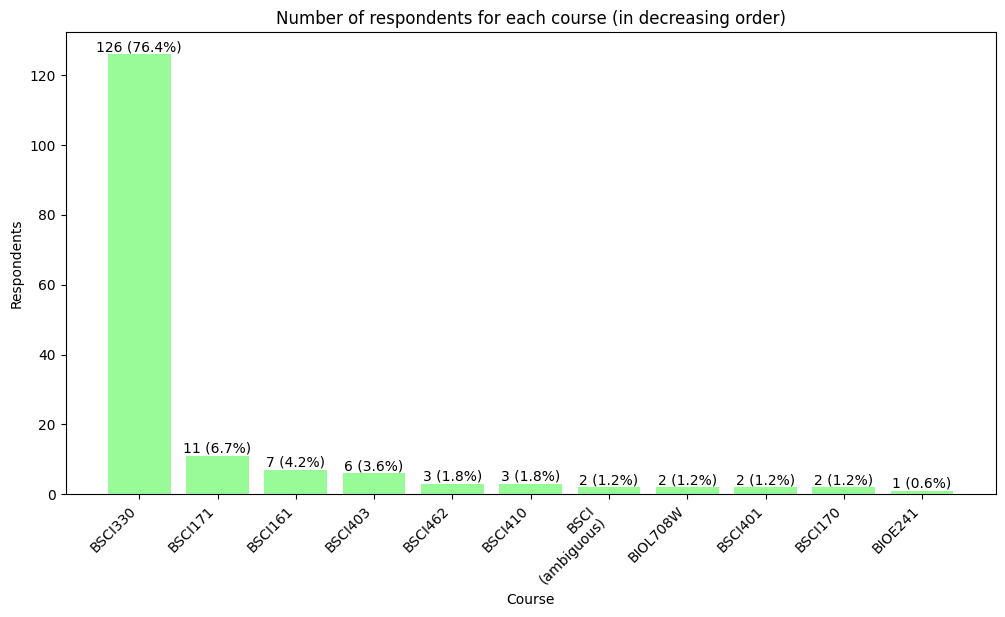

In [21]:
respondents = df['q1'].value_counts()   # y-values -- number of respondents
courses = respondents.index.tolist()    # x-values -- courses
sum_total = sum(respondents)            # total number of respondents

# generate bar chart
plt.figure(figsize=(12, 6))
plt.bar(courses, respondents, color='palegreen')

# add labels
plt.title('Number of respondents for each course (in decreasing order)')
plt.xlabel('Course')
plt.ylabel('Respondents')
plt.xticks(rotation=45, ha='right')

# display chart
ydisplay(courses, respondents, sum_total)
plt.show()

3. Generate a bar chart of courses grouped by category.

---

## Question 3
> If you had in-class computational biology instruction or assignments for BSCI required courses, please list their course identifiers here (e.g. BSCI100, BSCI101).

In [22]:
modify('q3')

---

## Question 4
> How much time have you spent completing computational biology coursework in all of your BSCI classes up to this point (include in-class and out-of-class time)?*

Define a function to generate a bar chart for Question 4:

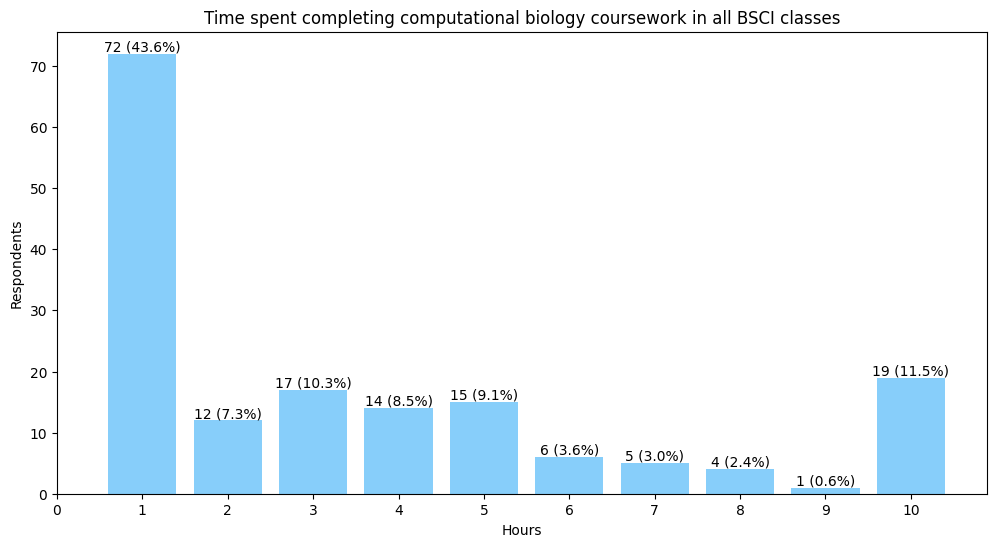

In [23]:
# Generates bar chart for Question 4.
def question4(responses, course=''):
    counts = responses.value_counts().sort_index()  # y-values -- number of respondents
    times = counts.index.tolist()                   # x-values -- hours
    total = sum(counts)                             # total number of respondents

    # generate bar chart
    plt.figure(figsize=(12, 6))
    plt.bar(times, counts, color='lightskyblue')

    # add labels
    if len(course) == 0:
        plt.title('Time spent completing computational biology coursework in all BSCI classes')
    else:
        plt.title(f'[{course}] Time spent completing computational biology coursework in all BSCI classes')
    plt.xticks(range(11))   # add ticks for 1-10 hours (inclusive)
    plt.xlabel('Hours')
    plt.ylabel('Respondents')

    # display chart
    ydisplay(times, counts, total, onlynum=True)
    plt.show()

question4(df['q4'])

---

## Question 10
> Are you graduating this semester (Spring 2024)?*

Define a function to generate a bar chart for Question 10:

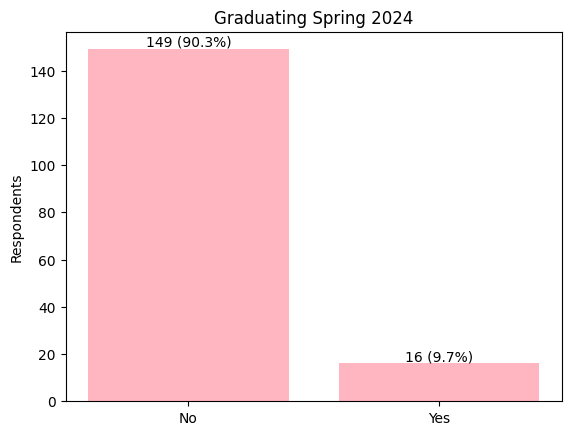

In [24]:
# Generates bar chart for Question 10.
def question10(responses, course=''):
    counts = responses.value_counts()   # y-values -- number of respondents
    answers = counts.index.tolist()     # x-values -- answers
    total = sum(counts)                 # total number of respondents

    # generate bar chart
    plt.bar(answers, counts, color='lightpink')

    # add labels
    if len(course) == 0:
        plt.title('Graduating Spring 2024')
    else:
        plt.title(f'[{course}] Graduating Spring 2024')
    plt.ylabel('Respondents')

    # display chart
    ydisplay(answers, counts, total)
    plt.show()

question10(df['q10'])

---

## Question 11
> Did your overall education at UMD (including outside of BSCI) in computational biology influence your ability to apply for or receive a job you wanted?**

Define a function to generate a bar chart for Question 11:

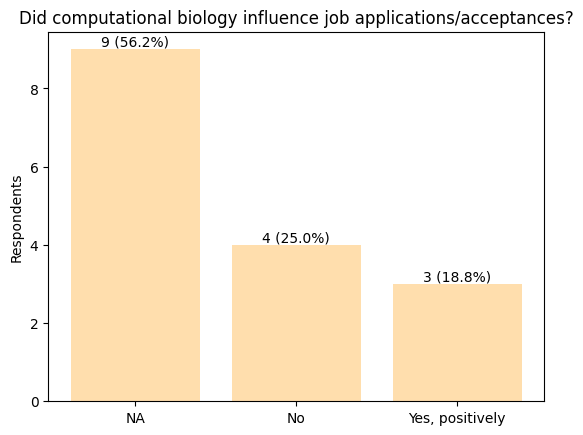

In [25]:
# Generates bar chart for Question 11.
def question11(responses, course=''):
    counts = responses.value_counts(dropna=False)   # y-values -- number of respondents
    counts.drop(labels='', inplace=True)            # drop empty responses (i.e., non-senior responses)
    answers = counts.index.tolist()                 # x-values -- answers
    total = sum(counts)                             # total number of respondents

    # generate bar chart
    plt.bar(answers, counts, color='navajowhite')

    # add labels
    if len(course) == 0:
        plt.title('Did computational biology influence job applications/acceptances?')
    else:
        plt.title(f'[{course}] Did computational biology influence job applications/acceptances?')
    plt.ylabel('Respondents')

    # display chart
    ydisplay(answers, counts, total)
    plt.show()

question11(df['q11'])

---

# Responses by course
## BSCI330

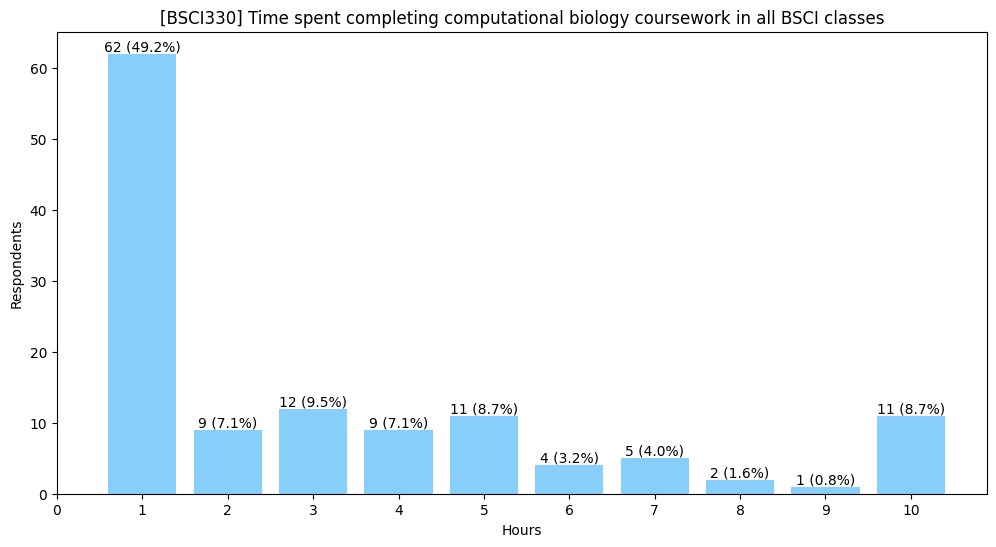

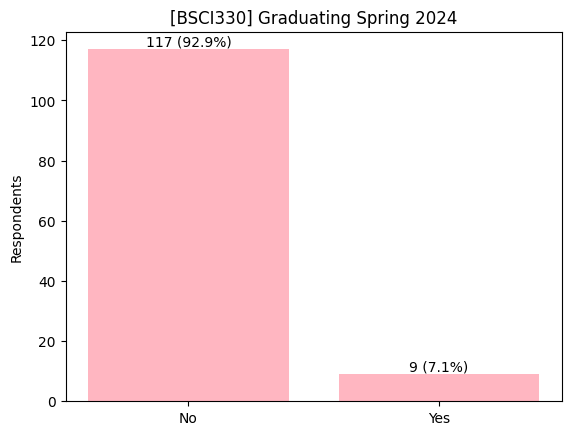

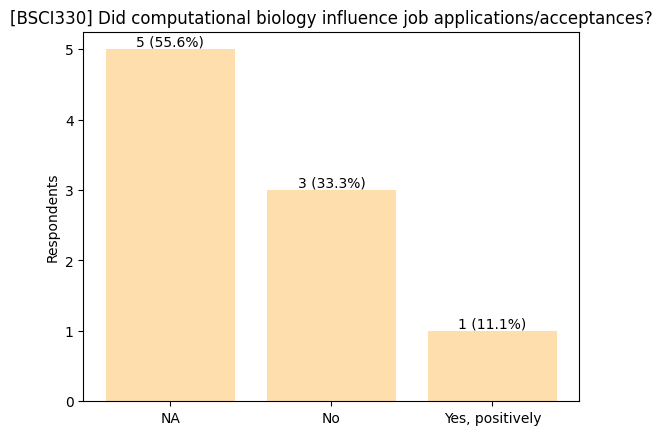

In [26]:
bsci330 = df[df.q1 == 'BSCI330']
question4(bsci330['q4'], 'BSCI330')
question10(bsci330['q10'], 'BSCI330')
question11(bsci330['q11'], 'BSCI330')